In [21]:
import torch
import torch.nn as nn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import scipy.special as special

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_path = 'Data/'

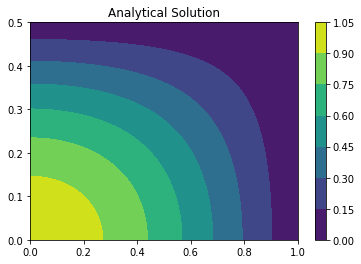

In [23]:
sigma_a = 0.45
sigma_s = 2
sigma_f = 0.5
vsigma_f = 2.5
d = 0.7104
D = 1/(3*(sigma_s + sigma_a))
B_g_square = (vsigma_f - sigma_a)/D
R_e_square = (np.pi**2 + 2.405**2) / B_g_square
R_e = R_e_square ** (1/2)
R = R_e - d
H_e = R_e
AC = 1/special.jv(0,0)


#analytical plot using this function
def Exact_u_func(x,y):
    u = AC*special.jv(0,(2.405/R_e)*x)*np.cos((np.pi/H_e)*y)
    return u

x_pred, y_pred = np.linspace(0,1,100), np.linspace(0,0.5,100)
X, Y = np.meshgrid(x_pred, y_pred)
x_p, y_p = X.flatten(), Y.flatten()
analytical_solution = Exact_u_func(x_p,y_p) 
plt.title('Analytical Solution')
plt.contourf(X,Y,analytical_solution.reshape(100,100),cmap='viridis')
plt.colorbar()

In [24]:
# generate collocation points here
x_points = np.random.uniform(0,1,200)
y_points = np.random.uniform(0,0.5,100)
X1, X2 = np.meshgrid(x_points,y_points)
x_res = X1.flatten().reshape(20000,1)
y_res = X2.flatten().reshape(20000,1)

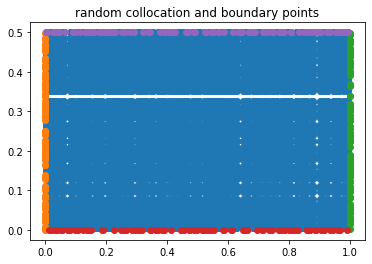

In [25]:
left_x = np.linspace(0,0,100).reshape(100,1)
left_y = np.random.uniform(0,0.5,100).reshape(100,1)
right_x = np.linspace(1,1,100).reshape(100,1)
right_y = np.random.uniform(0,0.5,100).reshape(100,1)
up_x  = np.random.uniform(0,1,100).reshape(100,1)
up_y = np.linspace(0.5,0.5,100).reshape(100,1)
down_x = np.random.uniform(0,1,100).reshape(100,1)
down_y = np.random.uniform(0,0,100).reshape(100,1)

plt.title('random collocation and boundary points')
plt.scatter(x_res,y_res)
plt.scatter(left_x,left_y)
plt.scatter(right_x,right_y)
plt.scatter(down_x,down_y)
plt.scatter(up_x,up_y)

In [26]:
class PINNS(nn.Module):
    def __init__(self):
        super(PINNS, self).__init__()
        self.layers = [2,40,40,40,40,40,40,40,40,1]
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.linear_layers = nn.ModuleList()
        self.init_linear_layers()
    
    def init_linear_layers(self):
        for i in range(len(self.layers) - 1):
            self.linear_layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            nn.init.xavier_normal_(self.linear_layers[-1].weight)

    def forward(self, x, y):
        X = torch.cat([x, y], 1)
        for layer in self.linear_layers[:-1]:
            X = torch.tanh(layer(X))

        output = self.linear_layers[-1](X)

        return output

In [27]:
def diff_x(a,b):
    da_db = torch.autograd.grad(a.sum(),b,create_graph=True)[0]
    return da_db
loss_function = torch.nn.MSELoss(reduction='mean')

def loss_func(pred,true=None):
    if true is None:
        true = torch.zeros_like(pred).to(device)
    return loss_function(pred,true)

def data_loader(x, requires_grad=True):
    x_array = np.array(x)
    x_tensor = torch.tensor(x_array,
                   requires_grad=requires_grad,
                            dtype=torch.float32,
                            device=device)
    return x_tensor


In [28]:
#turn raw data to tensor using the data_loader function
x_res = data_loader(torch.tensor(x_res))
y_res = data_loader(torch.tensor(y_res))
zero_point = data_loader([0],requires_grad=False).reshape(1,1)
l_b_1 = data_loader(left_x)
l_b_2 = data_loader(left_y)
d_b_1 = data_loader(down_x)
d_b_2 = data_loader(down_y)
u_b_x = data_loader(up_x) 
u_b_y = data_loader(up_y) 
r_b_x = data_loader(right_x)
r_b_y = data_loader(right_y)
B_g_square = data_loader(15.0675)

In [ ]:
t1 = time.time()
NN = PINNS()
NN.to(device)
lr = 1e-4
epochs = 5000
optimizer = torch.optim.Adam(NN.parameters(), lr=lr)

for i in range(epochs):
    optimizer.zero_grad()
    x_phy = x_res
    y_phy = y_res
        
    pinns_pred = NN(x_phy,y_phy)
    phi_x = diff_x(pinns_pred,x_phy)
    phi_xx = diff_x(phi_x,x_phy)
    phi_y = diff_x(pinns_pred,y_phy)
    phi_yy = diff_x(phi_y,y_phy)
    eqn = x_phy*(phi_xx + phi_yy + B_g_square*pinns_pred) + phi_x        
    loss_pde = loss_func(eqn)

    #loss boundary
    bc_left = NN(l_b_1,l_b_2) 
    bc_right = NN(r_b_x,r_b_y)
    bc_up = NN(u_b_x,u_b_y)
    bc_down = NN(d_b_1,d_b_2) 
    down_grad = diff_x(bc_down,d_b_2)
    left_grad = diff_x(bc_left,l_b_1)
        
    loss_bc = loss_func(down_grad) + loss_func(left_grad) + loss_func(bc_right) + loss_func(bc_up)
        
   #normalisation equal 1
    norm = NN(zero_point,zero_point)
    ones = torch.ones_like(norm).to(device)
    loss_norm = loss_func(norm,ones)
    loss = loss_pde + loss_bc + loss_norm
    loss.backward()

    optimizer.step()
    
    if i % 10 == 0:
        print(f' Iter: {i}, loss_pde: {loss_pde}, loss_bc: {loss_bc}, loss_norm:{loss_norm}')

torch.save(NN.state_dict(), 'cylindrical_pinns.pth')

start_time = time.time()
print(f'Training total time: {(t1 - start_time)/60} minutes')

In [34]:
predict_points_x = np.linspace(0,1,200) 
predict_points_y = np.linspace(0,0.5,200)
X_pred, Y_pred = np.meshgrid(predict_points_x,predict_points_y)
X_pred = X_pred.flatten()
Y_pred = Y_pred.flatten()

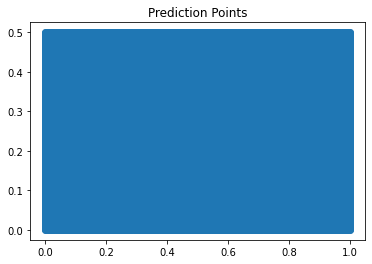

In [37]:
plt.title('Prediction Points')
plt.scatter(X_pred,Y_pred)

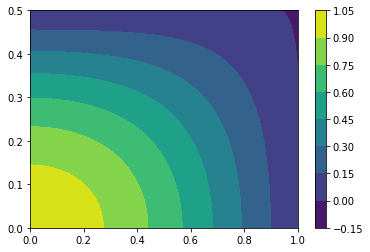

In [35]:
#Make prediction with saved .pth file because ran on gpu.

NN = PINNS()
model_path = 'cylindrical_pinns.pth'

NN.load_state_dict(torch.load(model_path, map_location=device))
NN.eval()
NN.to(device)
def data_loader(x,grad=True):
    x_tensor = torch.tensor(x,requires_grad=grad,dtype=torch.float32,device=device)
    return x_tensor

predict_x, predict_y = data_loader(X_pred, False).reshape(-1).unsqueeze(1), data_loader(Y_pred, False).reshape(-1).unsqueeze(1)
with torch.no_grad():
    predictions1 = NN(predict_x, predict_y)

predictions_flattened = predictions1.flatten()
plt.contourf(predict_x.reshape(200, 200), predict_y.reshape(200, 200), predictions1.reshape(200, 200))
plt.colorbar()